### veri seti hazırlığı

In [1]:
import pandas as pd
data = pd.read_excel('..\data\dataset4.xlsx')

In [2]:
data[0:10]

,Kelime,Etiket,Cumle
0,Corina,B-PERSON,0
1,Casanova,I-PERSON,0
2,bir,O,0
3,federal,O,0
4,parlementerdir,O,0
5,Casanova,B-PERSON,1
6,Hristiyan,B-ORG,1
7,Demokrat,I-ORG,1
8,Halk,I-ORG,1
9,Partisi,I-ORG,1


In [3]:
labels = list(data['Etiket'].unique())
labels_to_index = {t : i for i, t in enumerate(labels)}

In [4]:
index_to_labels = {i : t for i, t in enumerate(labels)}

In [5]:
data.Etiket = data.Etiket.apply(lambda label_str: labels_to_index[label_str])

In [6]:
data.count()

Kelime    26403
Etiket    26403
Cumle     26403
dtype: int64

In [7]:
data.groupby(by= 'Etiket').count()

,Kelime,Cumle
Etiket,,
0,1492,1492
1,954,954
2,19036,19036
3,776,776
4,797,797
5,1487,1487
6,436,436
7,797,797
8,628,628


In [9]:
data[data["Cumle"] == 65]

,Kelime,Etiket,Cumle
886,30,7,65
887,Kasım,8,65
888,1938de,8,65
889,Emil,0,65
890,Hcha,1,65
891,cumhurbaşkanı,2,65
892,olurken,2,65
893,Çek,3,65
894,Köylü,4,65
895,Partisi,4,65


In [10]:
data_test = data[data["Cumle"] < 414]
data_test.groupby(by= 'Etiket').count()

,Kelime,Cumle
Etiket,,
0,249,249
1,162,162
2,3765,3765
3,210,210
4,224,224
5,350,350
6,127,127
7,191,191
8,166,166


In [11]:
data_train = data[data["Cumle"] >= 414]
data_train.groupby(by= 'Etiket').count()

,Kelime,Cumle
Etiket,,
0,1243,1243
1,792,792
2,15271,15271
3,566,566
4,573,573
5,1137,1137
6,309,309
7,606,606
8,462,462


In [12]:
data_train.Kelime.count()

20959

In [13]:
data_test.Kelime.count()

5444

In [14]:
data_train.groupby(by='Cumle').sum().count()

Kelime    1653
Etiket    1653
dtype: int64

In [15]:
data_test.groupby(by='Cumle').sum().count()

Kelime    414
Etiket    414
dtype: int64

In [16]:
data_sentences = pd.DataFrame(columns=["sentence", "labels_index"])
for group_nu in range(len(data.Cumle.unique())):
    row_sentences = data.groupby("Cumle", group_keys = True).apply(lambda s:s).loc[group_nu]["Kelime"].values # sentences
    row_index_labels_sentences = data.groupby("Cumle", group_keys = True).apply(lambda s:s).loc[group_nu]["Etiket"].values # labels_sentences   
    data_sentences.loc[group_nu] = row_sentences, row_index_labels_sentences


### BERT model yukleme - uyum

In [17]:
from transformers import BertTokenizerFast
from transformers import DataCollatorForTokenClassification 
from transformers import AutoModelForTokenClassification
from sklearn.model_selection import train_test_split
from datasets import DatasetDict, Dataset
import pandas as pd
import numpy as np
from transformers import pipeline
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model

In [18]:
data_sentences.sentence = data_sentences.sentence.apply(lambda x: x.tolist())

In [19]:
data_sentences.labels_index = data_sentences.labels_index.apply(lambda x: x.tolist())

In [20]:
def cast_str(word_list):
    for word_indx in range(len(word_list)):
        word_list[word_indx] = str(word_list[word_indx])
    return word_list
data_sentences.sentence = data_sentences.sentence.apply(cast_str)

In [21]:
data_sentences[0:10]

,sentence,labels_index
0,"[Corina, Casanova, bir, federal, parlementerdir]","[0, 1, 2, 2, 2]"
1,"[Casanova, Hristiyan, Demokrat, Halk, Partisi,...","[0, 3, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."
2,"[İsviçrenin, dış, ilişkilerini, sürdürmekle, g...","[5, 2, 2, 2, 2]"
3,"[Denton, Amerika, Birleşik, Devletlerinde, Tek...","[5, 5, 6, 6, 5, 6, 5, 2, 2, 2]"
4,"[Coğrafi, olarak, Oklahoma, Teksas, sınırının,...","[2, 2, 5, 5, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2]"
5,"[Şehir, Kuzey, Teksasın, en, büyük, üniversite...","[2, 5, 6, 2, 2, 2, 2, 3, 4, 4, 2, 2, 7, 2, 2, ..."
6,"[Howard, Stark, Marvelın, kurgusal, bir, karak...","[0, 1, 3, 2, 2, 2]"
7,"[İlk, genel, gösteri, Dünya, Çapında, Pazarlam...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 1, 2, ..."
8,"[Ayrıca, belirtmek, gerekir, ki, 64, bit, x, 8...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."
9,"[Snow, Leopard, Yükseltme, lisansı, satın, alm...","[2, 2, 2, 2, 2, 2, 7, 8, 2, 8, 8, 8, 2, 2, 2, ..."


In [22]:
df_train = data_sentences[414:]
df_test = data_sentences[0:414]

In [23]:
df_train[0:10]

,sentence,labels_index
414,"[Prens, İvane, Andronikaşvili, veya, Knez, İva...","[0, 1, 1, 2, 0, 1, 1, 1, 5, 6, 2, 2, 2, 0, 2, ..."
415,"[Gruplarda, ilk, iki, sırayı, alan, dört, ülke...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 5, 2, 7, 8, ..."
416,"[AaB, Fodbold, Danimarkanın, Aalborg, kentinde...","[3, 4, 5, 5, 2, 2, 2, 2, 2]"
417,"[Danimarka, Süper, Liginde, mücadele, etmektedir]","[5, 3, 4, 2, 2]"
418,"[Üç, Süper, Lig, şampiyonluğu, ve, iki, Danima...","[2, 3, 4, 2, 2, 2, 3, 4, 2, 2]"
419,"[Dominic, OBrien, 10, Ağustos, 1957, Britanyal...","[0, 1, 7, 8, 8, 2, 2, 2, 2, 2, 2, 2, 2, 2]"
420,"[Dominic, OBrien, 1, Mayıs, 2002de, rastgele, ...","[0, 1, 7, 8, 8, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."
421,"[Sharon, Stone, d, 10, Mart, 1958, ABDli, sine...","[0, 1, 2, 7, 8, 8, 2, 2, 2]"
422,"[Pennsylvania, nın, Meadville, kentinde, dünya...","[5, 2, 5, 2, 2, 2]"
423,"[Dört, çocuğun, ikincisi, olup, Joe, ve, Dorot...","[2, 2, 2, 2, 0, 2, 0, 1, 2, 2]"


In [24]:
dataset_train = Dataset.from_pandas(df_train)

In [25]:
dataset_test = Dataset.from_pandas(df_test)

In [26]:
dataset_train

Dataset({
    features: ['sentence', 'labels_index', '__index_level_0__'],
    num_rows: 1653
})

In [27]:
dataset_test

Dataset({
    features: ['sentence', 'labels_index', '__index_level_0__'],
    num_rows: 414
})

In [28]:
#train_data, validation_data = train_test_split(dataset['train'], test_size=0.2, random_state=42)

# Create a DatasetDict with the training and validation sets
dataset_dict = DatasetDict({
    'train': dataset_train,
    'test': dataset_test
})

In [29]:
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['sentence', 'labels_index', '__index_level_0__'],
        num_rows: 1653
    })
    test: Dataset({
        features: ['sentence', 'labels_index', '__index_level_0__'],
        num_rows: 414
    })
})

In [30]:
tokenizer = BertTokenizerFast.from_pretrained("dbmdz/bert-base-turkish-cased")

In [31]:
example_text = dataset_dict['train']
example_text[2]

{'sentence': ['AaB',
  'Fodbold',
  'Danimarkanın',
  'Aalborg',
  'kentinde',
  'kurulan',
  'bir',
  'futbol',
  'takımı'],
 'labels_index': [3, 4, 5, 5, 2, 2, 2, 2, 2],
 '__index_level_0__': 416}

In [32]:
tokenized_input = tokenizer(example_text['sentence'][0], is_split_into_words = True)
tokenized_input

{'input_ids': [2, 14816, 204, 2920, 1025, 5683, 5310, 2549, 1026, 10621, 1024, 2382, 19525, 2125, 204, 2920, 4403, 24402, 13195, 5683, 5310, 6694, 2830, 3708, 20836, 22985, 15543, 27300, 5683, 5310, 2549, 1026, 10621, 1024, 14113, 7892, 29847, 1996, 19844, 2067, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [33]:
tokens = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"]),
tokens

(['[CLS]',
  'Prens',
  'İ',
  '##van',
  '##e',
  'And',
  '##ron',
  '##ika',
  '##ş',
  '##vil',
  '##i',
  'veya',
  'Kn',
  '##ez',
  'İ',
  '##van',
  'Mal',
  '##haz',
  '##oviç',
  'And',
  '##ron',
  '##nik',
  '##ov',
  'Rus',
  'Krallık',
  'hizmetinde',
  'çalışmış',
  'Gürcü',
  'And',
  '##ron',
  '##ika',
  '##ş',
  '##vil',
  '##i',
  'ailesine',
  'mensup',
  'soylu',
  'bir',
  'general',
  '##dir',
  '[SEP]'],)

In [34]:
#list mapping the tokens to their actual word in the initial sentence,
word_ids = tokenized_input.word_ids()
word_ids[0:10]
#Special tokens map to None

[None, 0, 1, 1, 1, 2, 2, 2, 2, 2]

In [35]:
#Problem of subtoken input ids returned by the tokenizer are longer than labels thatt dataset contains\n",
#transformes often pre-trained with subword tokenizers meaning even if your inputs already splits into words already\n",
#each of those words could be split again by the tokenizer we need to do some processing on labels\n",
#Because some speacial tokens might added example cls and the separotor token and possible spilits of words into multiple tokens\n",
len(example_text['labels_index']), len(tokenized_input["input_ids"])

(1653, 41)

In [36]:
example_text['labels_index'][0:10]

[[0, 1, 1, 2, 0, 1, 1, 1, 5, 6, 2, 2, 2, 0, 2, 2, 2, 2, 2],
 [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 5, 2, 7, 8, 8, 8, 2, 2, 3, 4, 2, 2, 2],
 [3, 4, 5, 5, 2, 2, 2, 2, 2],
 [5, 3, 4, 2, 2],
 [2, 3, 4, 2, 2, 2, 3, 4, 2, 2],
 [0, 1, 7, 8, 8, 2, 2, 2, 2, 2, 2, 2, 2, 2],
 [0, 1, 7, 8, 8, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 4, 2, 2],
 [0, 1, 2, 7, 8, 8, 2, 2, 2],
 [5, 2, 5, 2, 2, 2],
 [2, 2, 2, 2, 0, 2, 0, 1, 2, 2]]

In [37]:
tokenized_input["input_ids"][0:10]

[2, 14816, 204, 2920, 1025, 5683, 5310, 2549, 1026, 10621]

In [38]:

#set –100 as the label for these special tokens and the subwords we wish to mask during training\n",
#mask the subword representations after the first subword\n",
def tokenize_and_align_labels(examples, label_all_tokens = False):
    tokenized_inputs = tokenizer(examples["sentence"], truncation=True, is_split_into_words=True) 
    labels = []
    for i, label in enumerate(examples["labels_index"]): 
        word_ids = tokenized_inputs.word_ids(batch_index=i)
            # word_ids() => Return a list mapping the tokens\n",
            # to their actual word in the initial sentence.\n",
            # It Returns a list indicating the word corresponding to each token.
            #word_ids=[None, 0, 0, 1, 1, 2, 3, 3, 3, 4, 5, 5, 5, 5, 5, 6, None]
        previous_word_idx = None 
        label_ids = []
            # Special tokens like `<s>` and `<\\s>` are originally mapped to None 
            # We need to set the label to -100 so they are automatically ignored in the loss function.
        for word_idx in word_ids: 
            if word_idx is None: 
                    #set –100 as the label for these special tokens. This will be ignored in the training
                label_ids.append(-100)
                 # For the other tokens in a word, we set the label to either the current label or -100, depending on
                 # the label_all_tokens flag.
            elif word_idx < len(label) and label[word_idx] is not None:
                try:
                    #Yani yeni kelimeye geçmişse\n",
                     # if current word_idx is != prev then its the most regular case\n",
                    # and add the corresponding token\n",
                    #print(label)
                    #print(word_idx)
                    label_ids.append(label[word_idx]) 
                    previous_word_idx = word_idx
                    
                except:
                    continue
            elif label_all_tokens:
                    # set –100 as the label for subword tokens if label_all_tokens is True
                label_ids.append(-100)
            else:
                    #Aynı kelimeyse\n",
                  # to take care of sub-words which have the same word_idx
                  # set -100 as well for them, but only if label_all_tokens == False
                label_ids.append(label[word_idx] if label_all_tokens else -100) 
                  # mask the subword representations after the first subword
                      
            previous_word_idx = word_idx 
        labels.append(label_ids) 
    tokenized_inputs["labels"] = labels 
    return tokenized_inputs 
   

In [39]:
#fonksiyon tokenize_input_variable a labels ekledi\n",
q = tokenize_and_align_labels(dataset_dict['train'][8:9]) 
print(q) 

{'input_ids': [[2, 7591, 22958, 25692, 2920, 4475, 2732, 8223, 2204, 24967, 11895, 6325, 3381, 3]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], 'labels': [[-100, 5, 5, 5, 5, 5, 2, 5, 5, 5, 2, 2, 2, -100]]}


In [40]:
for token, label in zip(tokenizer.convert_ids_to_tokens(q["input_ids"][0]),q["labels"][0]): 
    print(f"{token:_<40} {label}")

[CLS]___________________________________ -100
Pen_____________________________________ 5
##ns____________________________________ 5
##yl____________________________________ 5
##van___________________________________ 5
##ia____________________________________ 5
nın_____________________________________ 2
Me______________________________________ 5
##ad____________________________________ 5
##ville_________________________________ 5
kentinde________________________________ 2
dünyaya_________________________________ 2
geldi___________________________________ 2
[SEP]___________________________________ -100


In [41]:
tokenized_datasets = dataset_dict.map(tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/1653 [00:00<?, ? examples/s]

Map:   0%|          | 0/414 [00:00<?, ? examples/s]

In [42]:
model = AutoModelForTokenClassification.from_pretrained("dbmdz/bert-base-turkish-cased", num_labels=len(labels_to_index))   

Some weights of the model checkpoint at dbmdz/bert-base-turkish-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initiali

In [43]:
from transformers import TrainingArguments, Trainer 
args = TrainingArguments( 
"test-ner",
learning_rate=2e-5, 
per_device_train_batch_size=1, 
num_train_epochs=3, 
weight_decay=0.01, 
) 

In [44]:
data_collator = DataCollatorForTokenClassification(tokenizer)

In [45]:
trainer = Trainer( 
    model, 
    args, 
   train_dataset = tokenized_datasets["train"], 
   data_collator=data_collator, 
   tokenizer=tokenizer, 
) 

In [47]:
trainer.train()

  0%|          | 0/4959 [00:00<?, ?it/s]

{'loss': 0.455, 'learning_rate': 1.7592256503327286e-05, 'epoch': 0.3}
{'loss': 0.3492, 'learning_rate': 1.5575720911474088e-05, 'epoch': 0.6}
{'loss': 0.307, 'learning_rate': 1.3559185319620894e-05, 'epoch': 0.91}
{'loss': 0.2296, 'learning_rate': 1.1542649727767695e-05, 'epoch': 1.21}
{'loss': 0.205, 'learning_rate': 9.526114135914499e-06, 'epoch': 1.51}
{'loss': 0.1869, 'learning_rate': 7.509578544061303e-06, 'epoch': 1.81}
{'loss': 0.152, 'learning_rate': 5.493042952208107e-06, 'epoch': 2.12}
{'loss': 0.0981, 'learning_rate': 3.4765073603549103e-06, 'epoch': 2.42}
{'loss': 0.0834, 'learning_rate': 1.4599717685017142e-06, 'epoch': 2.72}
{'train_runtime': 8156.4672, 'train_samples_per_second': 0.608, 'train_steps_per_second': 0.608, 'train_loss': 0.2188805643409749, 'epoch': 3.0}


TrainOutput(global_step=4959, training_loss=0.2188805643409749, metrics={'train_runtime': 8156.4672, 'train_samples_per_second': 0.608, 'train_steps_per_second': 0.608, 'train_loss': 0.2188805643409749, 'epoch': 3.0})

In [ ]:
model.save_pretrained("bert_model")

In [ ]:
tokenizer.save_pretrained("tokenizer")

('tokenizer\\tokenizer_config.json',
 'tokenizer\\special_tokens_map.json',
 'tokenizer\\vocab.txt',
 'tokenizer\\added_tokens.json',
 'tokenizer\\tokenizer.json')

## model yukleme ve kullanım

In [48]:
import json
config = json.load(open('../models/bert_model/config.json'))

In [49]:
config["id2label"] = index_to_labels
config["label2id"] = labels_to_index

In [50]:
json.dump(config, open('../models/bert_model/config.json',"w"))

In [51]:
model_fine_tuned = AutoModelForTokenClassification.from_pretrained('../models/bert_model')


In [52]:
nlp = pipeline("ner", model=model_fine_tuned, tokenizer=tokenizer)

In [53]:
index_to_labels

{0: 'B-PERSON',
 1: 'I-PERSON',
 2: 'O',
 3: 'B-ORG',
 4: 'I-ORG',
 5: 'B-LOC',
 6: 'I-LOC',
 7: 'B-DATE',
 8: 'I-DATE'}

In [54]:
labels_to_index['PAD']=9

In [55]:
labels_to_index['PAD']=9
index_to_labels[9]='PAD'


In [56]:
labels.append('PAD')

In [57]:
labels

['B-PERSON',
 'I-PERSON',
 'O',
 'B-ORG',
 'I-ORG',
 'B-LOC',
 'I-LOC',
 'B-DATE',
 'I-DATE',
 'PAD']

In [58]:
sentences = data_sentences.sentence.to_list()
max_length = max(len(s) for s in sentences)
max_length

43

In [59]:
y_test=df_test['labels_index'].tolist()
X_test=df_test['sentence'].tolist()

In [60]:
y_test = pad_sequences(y_test, maxlen=max_length, padding="post", value = labels_to_index["PAD"])

In [61]:
y_test

array([[0, 1, 2, ..., 9, 9, 9],
       [0, 3, 4, ..., 9, 9, 9],
       [5, 2, 2, ..., 9, 9, 9],
       ...,
       [7, 2, 2, ..., 9, 9, 9],
       [3, 2, 3, ..., 9, 9, 9],
       [0, 1, 2, ..., 9, 9, 9]])

In [ ]:
sent= str(input())

In [64]:
def predict(sentence):
    #str_word_char_range = {"türkiyenin": [0,9], ...}
    #example = ["Türkiyenin başkenti Ankara'dır."]
    # Mustafa Kemal Paşa 19 Mayıs 1919'da Samsun'a çıktı
    # 5 Ekim'de Bursa Uludağ Üniversitesine gidilecek.
    example = [sentence]
    str_word_char_range = {}
    words_list = str(example[0]).split()
    start=0
    for word in words_list:
        str_word_char_range[word] = [start,start+len(word)]
        start = start+len(word)+1
    ner_results = nlp(example)
    counter_word_list = 0
    counter_ner_result = 0
    VIT_list = {}
    for counter_ner_result in range(len(ner_results[0])):
        range_word = str_word_char_range[words_list[counter_word_list]]
        if (ner_results[0][counter_ner_result]["start"] in range(range_word[0], range_word[1]+1)) and (ner_results[0][counter_ner_result]["end"] in range(range_word[0], range_word[1]+1)):     
            VIT_list[str(words_list[counter_word_list])] = str(ner_results[0][counter_ner_result]["entity"])
            counter_word_list += 1
        if counter_word_list == len(words_list):
            break
    for i in range(len(words_list)):
        try:
            VIT_list[words_list[i]] 
        except KeyError:
            VIT_list[words_list[i]] = "O"
    return VIT_list

In [65]:
a = predict("Türkiyenin başkenti Ankara'dır.").values()

In [66]:
" ".join(x for x in a)

'B-LOC O O'

In [67]:
preds_label_indexs=[]
for i in range (len(X_test)):
    preds_label_indexs.append(predict(' '.join(X_test[i])))

In [71]:
preds_label_indexs[:10]

[{'Corina': 'B-PERSON',
  'Casanova': 'I-PERSON',
  'bir': 'O',
  'federal': 'O',
  'parlementerdir': 'O'},
 {'Casanova': 'B-PERSON',
  'Hristiyan': 'B-ORG',
  'Demokrat': 'I-ORG',
  'Halk': 'I-ORG',
  'Partisi': 'I-ORG',
  'üyesi': 'O',
  'üyedidir': 'O',
  've': 'O',
  'altı': 'O',
  'dilde': 'O',
  'konuşmaktadır': 'O',
  'Romanş': 'O',
  'dili': 'O',
  'Almanca': 'O',
  'Fransızca': 'O',
  'İtalyanca': 'O',
  'İngilizce': 'O',
  'İspanyolca': 'O',
  'İsviçre': 'O',
  'Dışişleri': 'O',
  'Bakanlığı': 'O',
  'federal': 'O',
  'yönetiminin': 'O',
  'bir': 'O',
  'bölümüdür': 'O'},
 {'İsviçrenin': 'B-LOC',
  'dış': 'O',
  'ilişkilerini': 'O',
  'sürdürmekle': 'O',
  'görevlidir': 'O'},
 {'Denton': 'B-LOC',
  'Amerika': 'O',
  'Birleşik': 'O',
  'Devletlerinde': 'O',
  'Teksas': 'O',
  'eyaletinin': 'O',
  'bölgesindeki': 'O',
  'bir': 'O',
  'şehirdir': 'O'},
 {'Coğrafi': 'O',
  'olarak': 'O',
  'Oklahoma': 'O',
  'Teksas': 'O',
  'sınırının': 'O',
  '61': 'O',
  'kilometre': 'O',
  'g

In [ ]:
y_prediction = pad_sequences(preds_label_indexs, maxlen=max_length, padding="post", value = labels_to_index["PAD"])

In [ ]:
y_test.shape

(414, 43)

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

# Calculate F1 score
f1 = f1_score(y_test.reshape((len(y_test)*max_length),1), y_prediction.reshape((len(y_test)*max_length),1),average=None)

In [ ]:
for class_id, f1 in enumerate(f1):
    print(" {}: F1 score: {}".format(index_to_labels[class_id], f1))

 B-PERSON: F1 score: 0.5280898876404494
 I-PERSON: F1 score: 0.5606694560669456
 O: F1 score: 0.843643219040886
 B-ORG: F1 score: 0.26666666666666666
 I-ORG: F1 score: 0.21374045801526717
 B-LOC: F1 score: 0.47010309278350515
 I-LOC: F1 score: 0.29870129870129875
 B-DATE: F1 score: 0.4961832061068703
 I-DATE: F1 score: 0.3796296296296296
 PAD: F1 score: 0.992928318868531


In [ ]:
print(classification_report(y_test.reshape((len(y_test)*max_length),1), y_prediction.reshape((len(y_test)*max_length),1), target_names=labels))

              precision    recall  f1-score   support

    B-PERSON       0.88      0.38      0.53       249
    I-PERSON       0.87      0.41      0.56       162
           O       0.76      0.95      0.84      3765
       B-ORG       0.76      0.16      0.27       210
       I-ORG       0.74      0.12      0.21       224
       B-LOC       0.84      0.33      0.47       350
       I-LOC       0.85      0.18      0.30       127
      B-DATE       0.92      0.34      0.50       191
      I-DATE       0.82      0.25      0.38       166
         PAD       0.99      1.00      0.99     12358

    accuracy                           0.92     17802
   macro avg       0.84      0.41      0.51     17802
weighted avg       0.92      0.92      0.91     17802



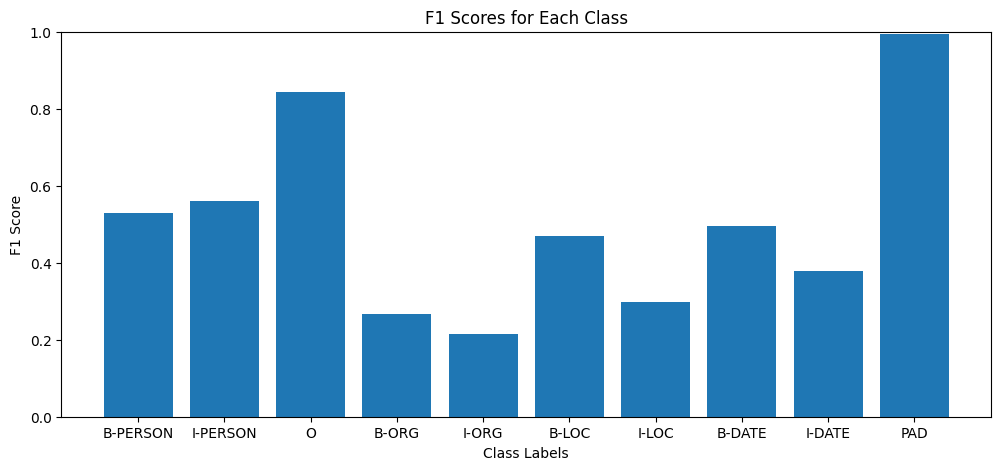

In [ ]:
import matplotlib.pyplot as plt
f1 = f1_score(y_test.reshape((len(y_test)*max_length),1), y_prediction.reshape((len(y_test)*max_length),1),average=None)
plt.figure(figsize=(12, 5))
plt.bar(labels, f1.tolist())
plt.xlabel('Class Labels')
plt.ylabel('F1 Score')
plt.title('F1 Scores for Each Class')
plt.xticks(labels)
plt.ylim(0, 1)  # Optional: Set the y-axis limits
plt.show()

In [ ]:
predict('Albert Einstein ünlü bir fizikçi ve teorik fizik alanında bir dahi olarak tanınır')

{'Albert': 'B-PERSON', 'Einstein': 'I-PERSON', 'ünlü': 'O', 'bir': 'O', 'fizikçi': 'O', 've': 'O', 'teorik': 'O', 'fizik': 'O', 'alanında': 'O', 'dahi': 'O', 'olarak': 'O', 'tanınır': 'O'}


[0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]